In [32]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub/prj_on_boarding")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub/prj_on_boarding


# 1. data load

In [33]:
df = pd.read_csv("/Users/yj.noh/Desktop/on_boarding_data.csv", encoding = "cp949")
print(df.head(2))
print(df.isna().sum())

                                       brms_rider_id  birth delivery_method  \
0  E9AD475E050C07D27DE95100785EBE41480790A6D30E2E...   1980            WALK   
1  CAC046CE43D32CA3C29830A829D1E6FD3D7E11B397BF0F...   1970            BIKE   

  insurance_type first_available_date business_start_day  is_recom gender  \
0   NOT_REQUIRED           2020-07-21         2023-08-26         0    MAN   
1       PERSONAL           2020-09-12         2023-08-19         0    MAN   

   active_days  avg_daily_delivery  avg_distance      avg_fee  \
0            1                 7.0    434.571429  3187.142857   
1            2                36.5   2669.465753  6077.808219   

  last_working_day  outcome  
0       2023-08-26        1  
1       2023-08-20        1  
brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
active_days             0
avg_daily_

In [34]:
#data_filter = df[((df['day_cnt'].notnull()) & (df['delivery_method'] == 'BIKE') & (df['is_recom'] == 0))]
#data_filter = df[((df['day_cnt'].notnull()) & (df['delivery_method'] == 'BIKE'))]

print(df.isna().sum())
print(df.shape) # 7,946건 

brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
active_days             0
avg_daily_delivery      0
avg_distance            0
avg_fee                 0
last_working_day        0
outcome                 0
dtype: int64
(7946, 14)


In [35]:
print(df['outcome'].value_counts()) # 4,010, 3,936

outcome
0    4010
1    3936
Name: count, dtype: int64


# 2. 그래프 그리기

In [36]:
category_vars = ['birth', 'delivery_method', 'insurance_type', 'is_recom', 'gender']
num_vars = ['active_days', 'avg_daily_delivery', 'avg_distance', 'avg_fee']

## 2-1. numeric

In [37]:
# palette = plasma, coolwarm, magma, BuGn, Dark2 
def plot_numeric (data, numeric_vars, outcome):
    
    os.makedirs('graphs/all', exist_ok = True)
    
    palette = 'coolwarm'
    
    mapping = {0 : '미이탈', 1 : '이탈'}
    data[outcome] = data[outcome].replace(mapping)
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        fig.suptitle(f'{num_var} 분포', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0], x= outcome, y=num_var, data= data, palette = palette)
        axs[0].set_title('Boxplot')
    
        # Violinplot
        sns.violinplot(ax=axs[1], x = outcome, y = num_var, data = data, palette = palette)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, hue = outcome, fill = True, common_norm = False, palette = palette, alpha=.5, linewidth=0)
        axs[2].set_title('Density plot')
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) # title 공간 확보
        
        fig.savefig(f'graphs/all/{num_var}_distributions.png')
        plt.show()
        plt.close(fig)
        
        

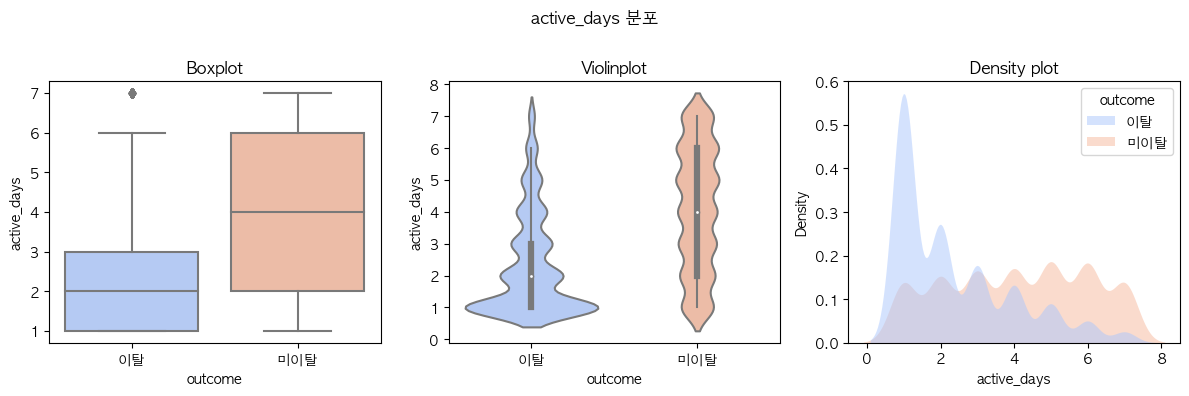

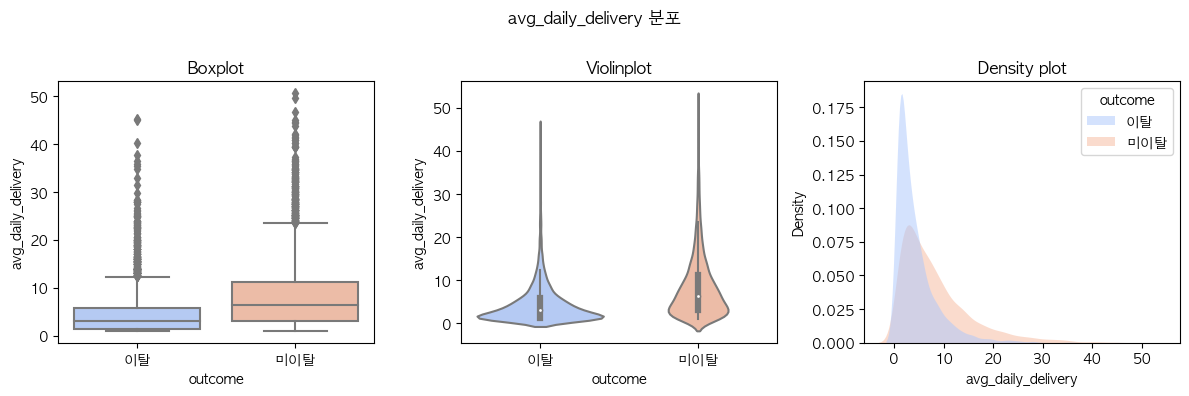

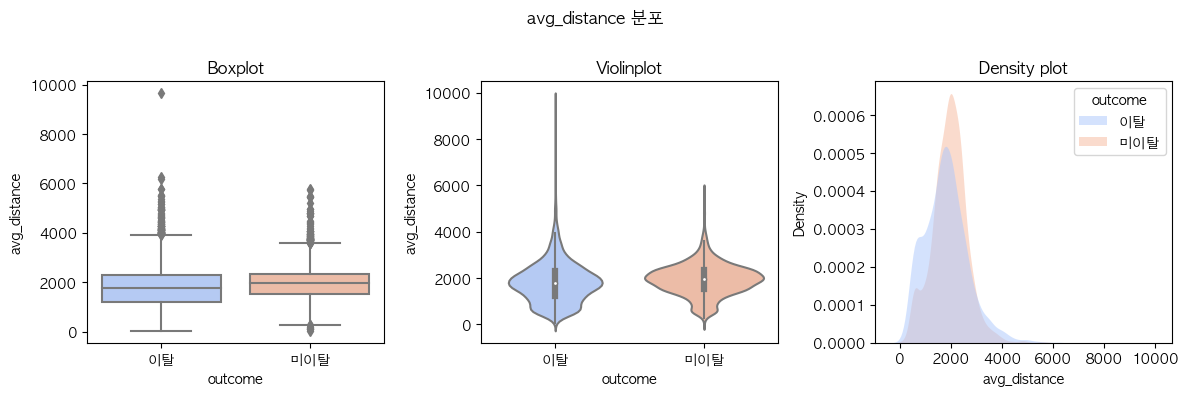

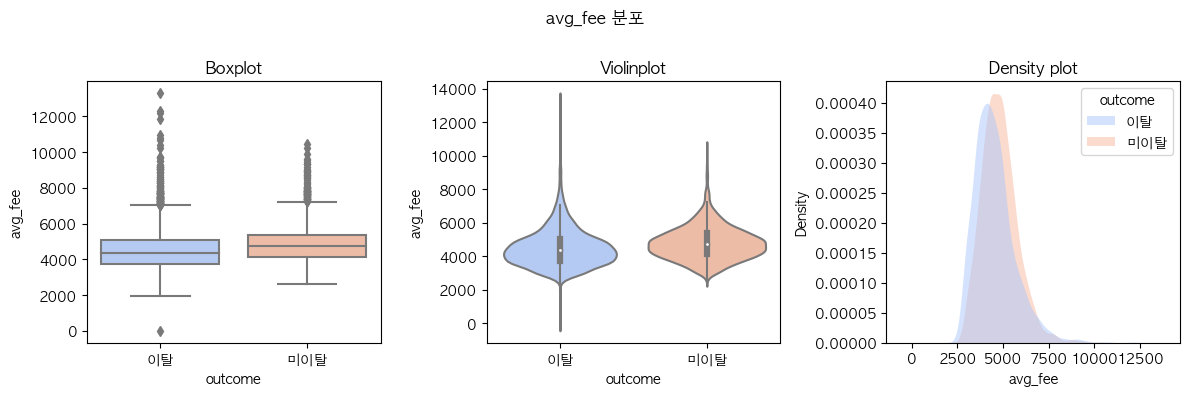

In [38]:
plot_numeric(df, num_vars, 'outcome')

In [39]:
# plt.figure(figsize=(8,6))
# sns.boxplot(data=data_filter, x='outcome', y='avg_cnt')
# plt.title("outcome 별 일평균수행처리건수")
# plt.savefig("prj_on_boarding/boxplot1.png")
# plt.show()

# plt.figure(figsize=(8,6))
# sns.boxplot(data=data_filter, x='outcome', y='day_cnt')
# plt.title("outcome 별 수행일수")
# plt.savefig("prj_on_boarding/boxplot2.png")
# plt.show()

# # day_cnt
# plt.figure(figsize=(8,6))
# sns.violinplot(x='outcome', y='day_cnt', data=data_filtered_both)
# plt.title('Distribution of day_cnt by outcome')
# plt.show()

# # avg_cnt
# plt.figure(figsize=(8,6))
# sns.violinplot(x='outcome', y='avg_cnt', data=data_filtered_both)
# plt.title('Distribution of avg_cnt by outcome')
# plt.show()


## 2.2 category 변수

In [40]:
def plot_category(data, category_vars, outcome) : 
    
    # outcome 값 변경
    mapping  = {0 : '미이탈', 1 : '이탈'}
    data[outcome] = data[outcome].replace(mapping)
    
    palette = 'coolwarm'
    
    # 저장할 디렉토리 생성
    os.makedirs('graphs', exist_ok = True)
    
    for cat_var in category_vars : 
        plt.figure(figsize = (12,4))
        ax = sns.countplot(x=cat_var, hue=outcome, data=data, palette=palette)
        plt.title(f'이탈여부에 따른 {cat_var} 분포')
        plt.ylabel('개수')
        plt.legend(title=outcome, loc='upper right')
        plt.xticks(fontsize=8)  # x축 글씨 조정
        
        # 각 막대에 데이터 레이블 추가
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',  # 높이 값(즉, 개수)을 얻어 텍스트로 설정
                        (p.get_x() + p.get_width() / 2., p.get_height()),  # 텍스트 위치 설정
                        ha='center',  # 가로 정렬(center)
                        va='center',  # 세로 정렬(center)
                        xytext=(0, 10),  # 텍스트 오프셋(위쪽으로 약간 이동)
                        textcoords='offset points',  # 어떤 종류의 오프셋을 사용할지 정의
                        fontsize=10)  # 글꼴 크기
        
        
        plt.tight_layout()
        plt.savefig(f'graphs/all/{cat_var}_distributions.png')
        plt.show()
        
       

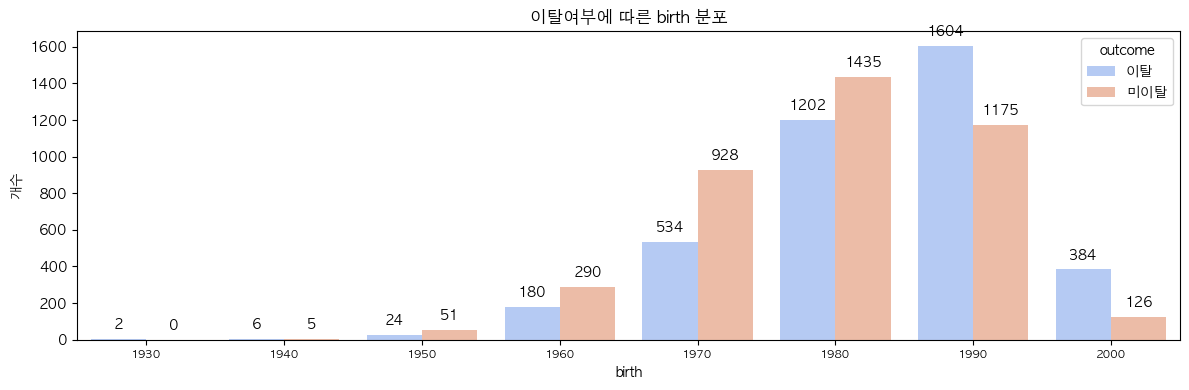

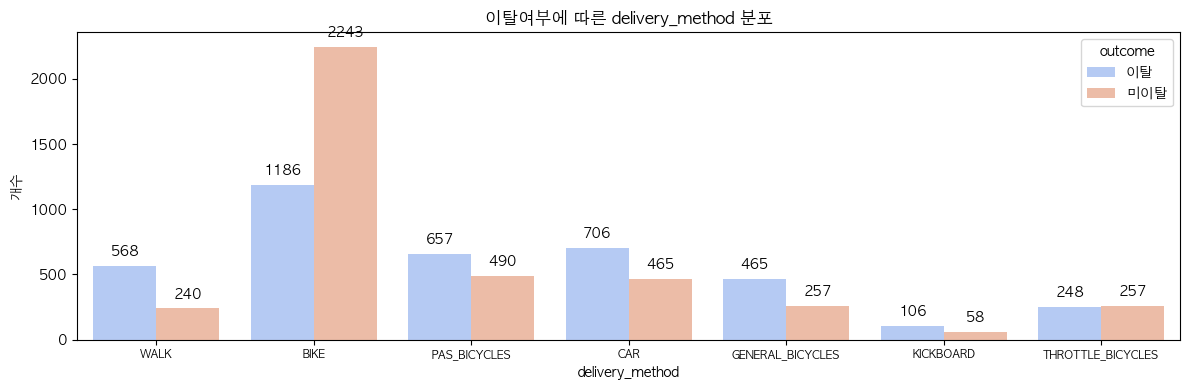

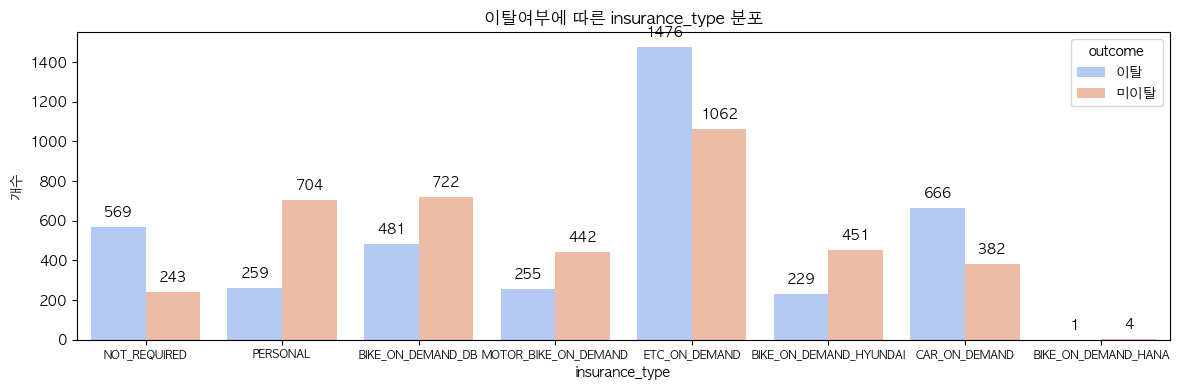

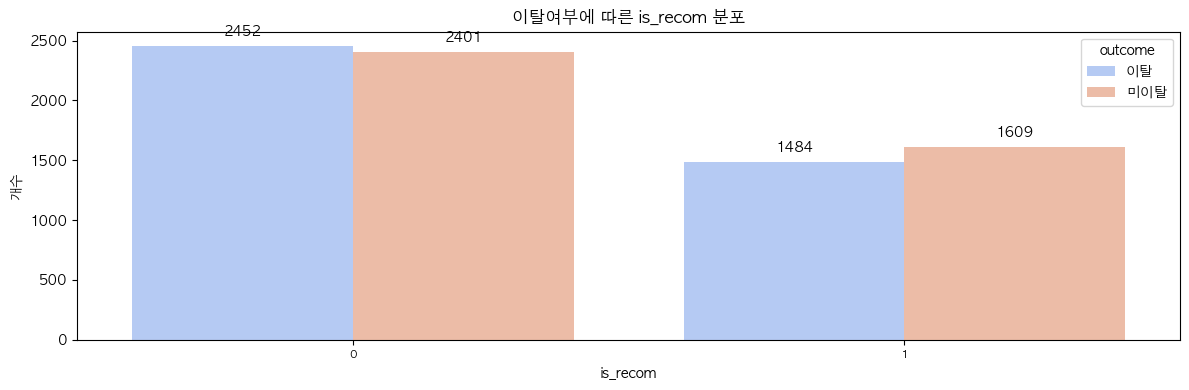

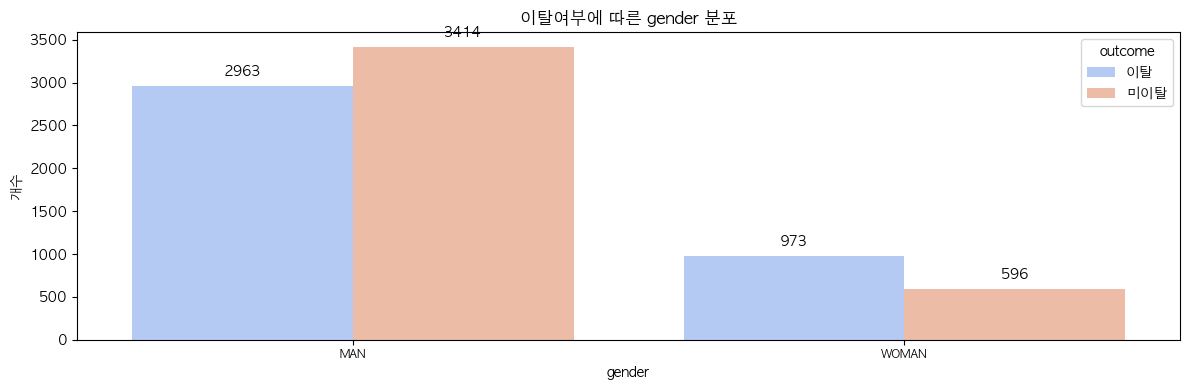

In [41]:
plot_category(df, category_vars, 'outcome')

## 3. BIKE만 대상으로 진행 

In [42]:
data_bike = df[(df['delivery_method'] == 'BIKE')]

print(data_bike.shape)
print(data_bike['delivery_method'].value_counts()) #3,429

(3429, 14)
delivery_method
BIKE    3429
Name: count, dtype: int64


# 3-1.numeric - outlier 제거

In [43]:
# 이탈 값 되돌리기
mapping  = { '미이탈' : 0 ,  '이탈' : 1}
data_bike['outcome'] = data_bike['outcome'].replace(mapping)

# outlier 제거  - outcome 별로 나눠서 
def remove_outliers(df, column):
    Q1 = df.groupby('outcome')[column].quantile(0.25)
    Q3 = df.groupby('outcome')[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[df.apply(lambda x: (x[column] >= lower_bound[x['outcome']]) & 
                                 (x[column] <= upper_bound[x['outcome']]), axis=1)]


In [44]:
# 'avg_cnt'와 'day_cnt'에 대한 아웃라이어 제거
data_filtered_avg = remove_outliers(data_bike, 'active_days')
data_filtered_both = remove_outliers(data_bike, 'avg_daily_delivery')

print(data_filtered_both.shape)  
print(data_filtered_both['outcome'].value_counts())

data_filtered_both.to_excel('data_filtered_both.xlsx', index=False, engine='openpyxl') # 3,393 / 2,255, 1,138

(3291, 14)
outcome
0    2169
1    1122
Name: count, dtype: int64


# 3-2 그래프 확인

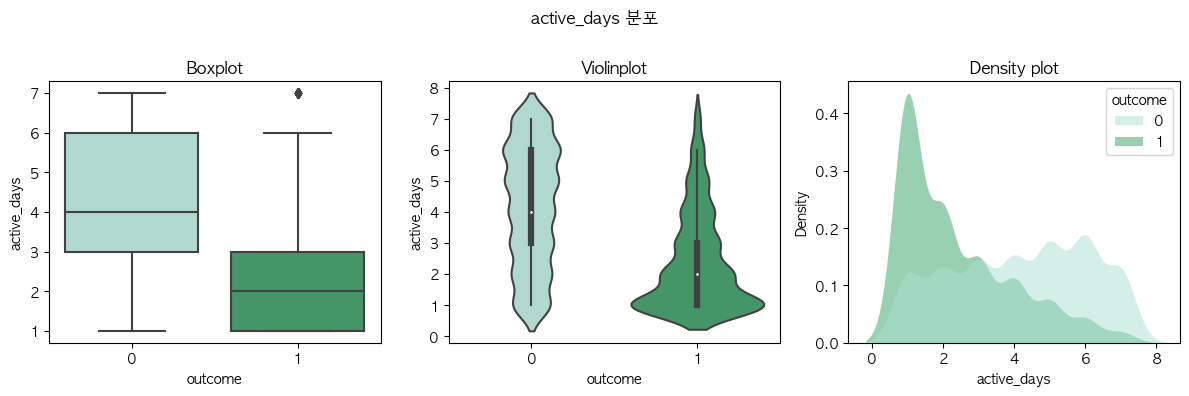

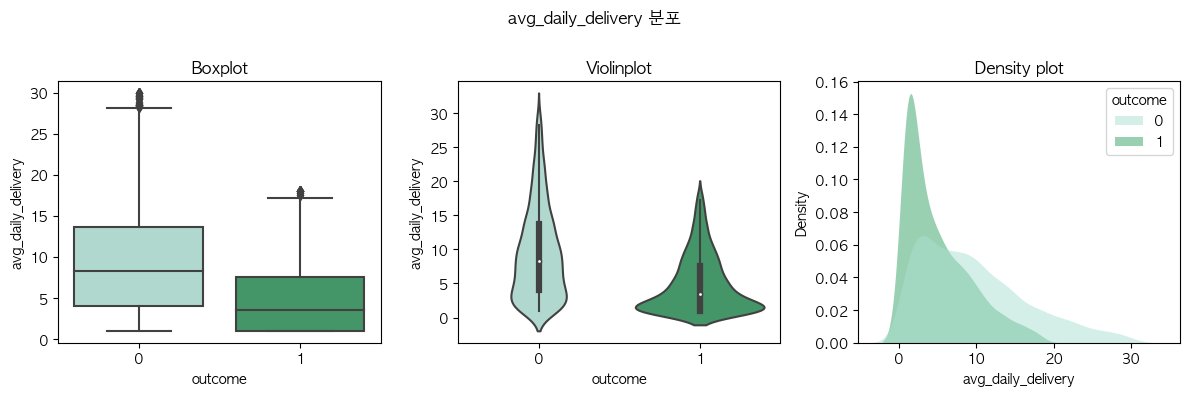

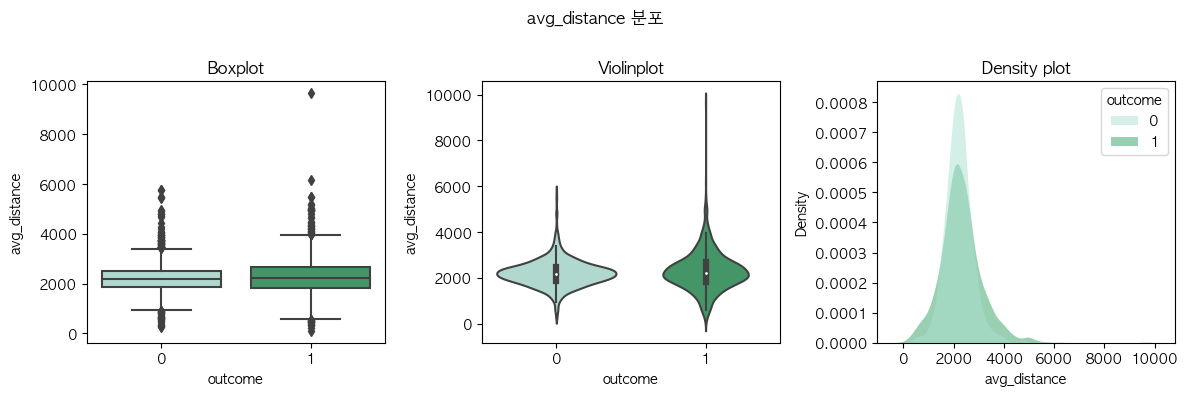

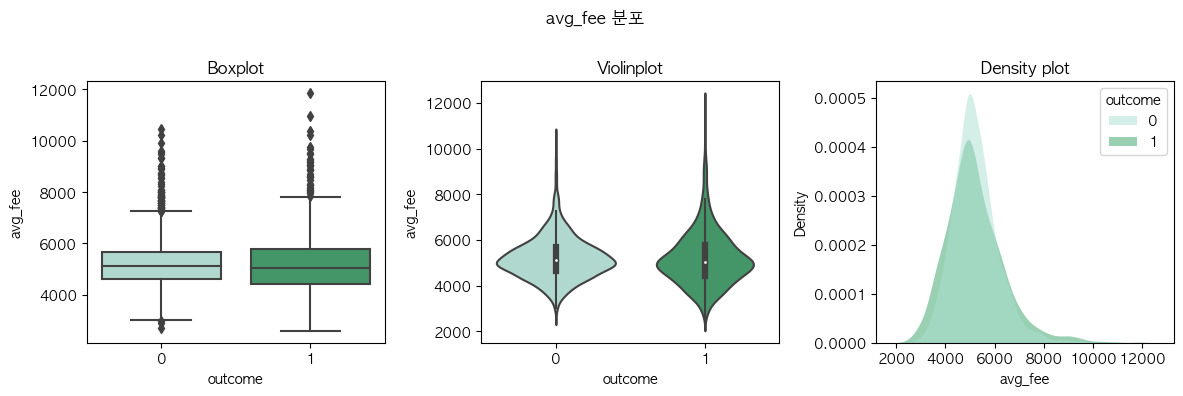

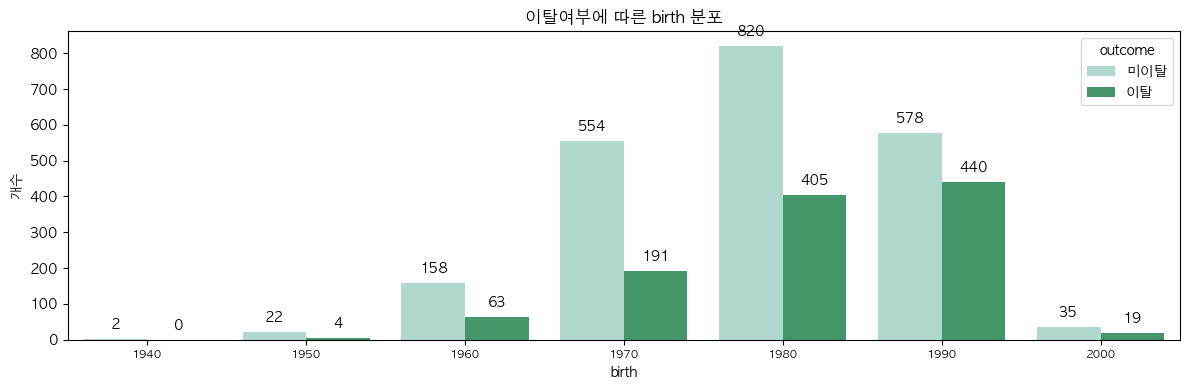

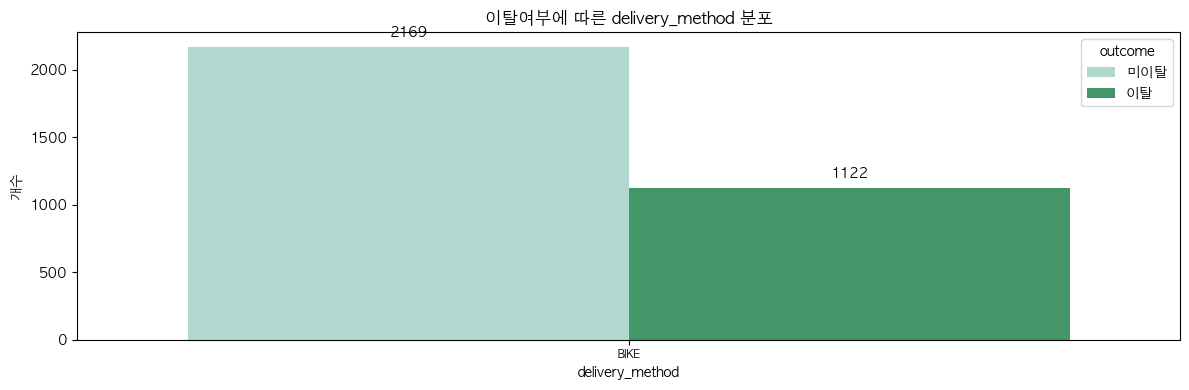

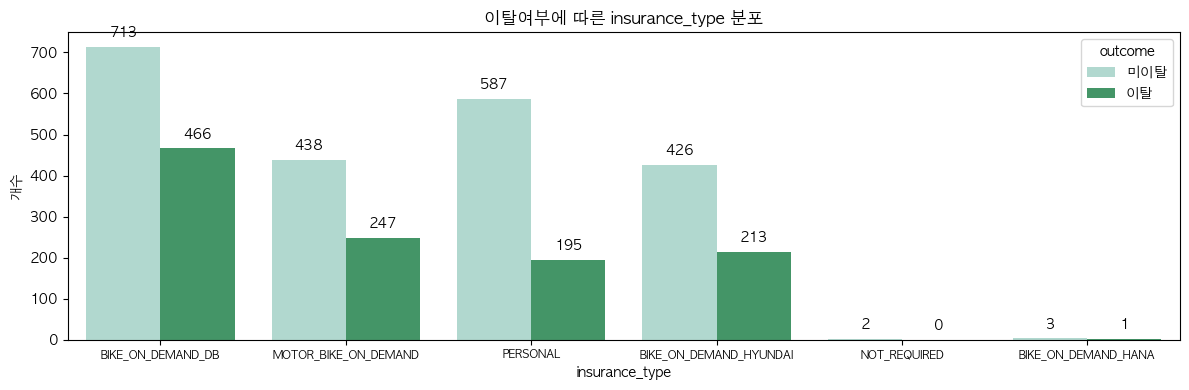

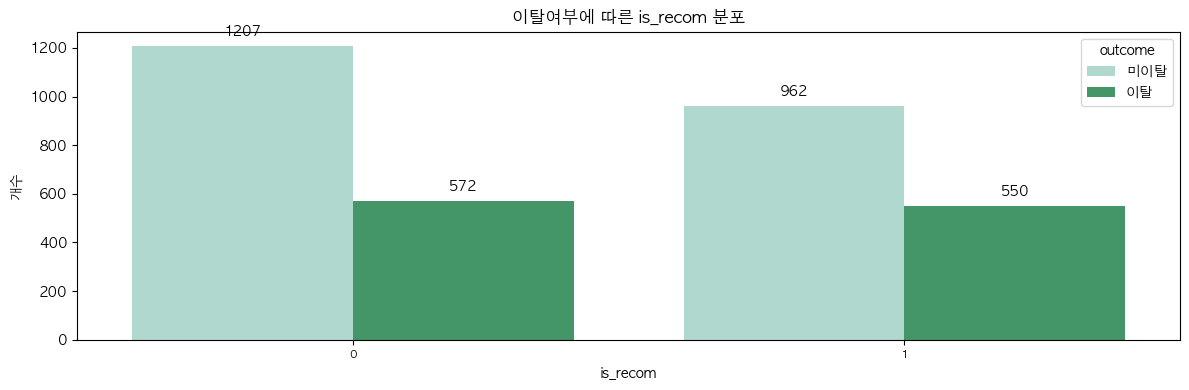

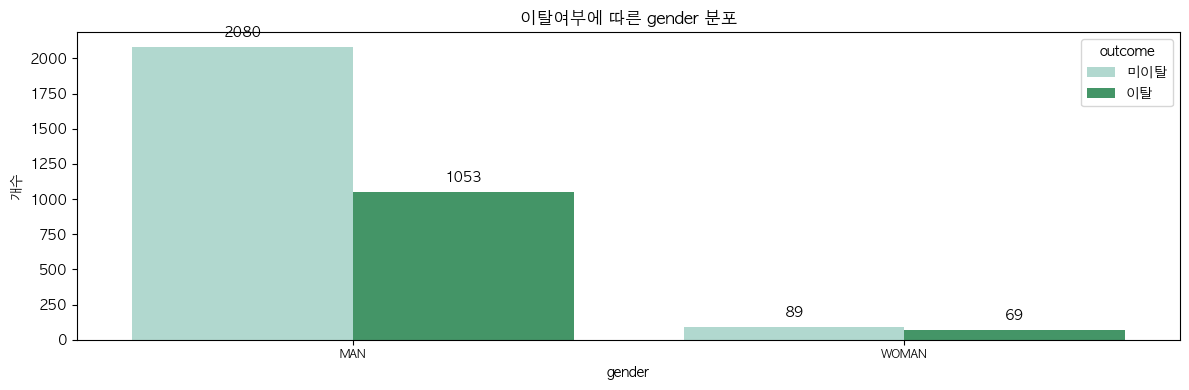

In [45]:
# palette = plasma, coolwarm, magma, BuGn, Dark2 
def plot_numeric (data, numeric_vars, outcome):
    
    os.makedirs('graphs/bike', exist_ok = True)
    
    palette = 'BuGn'
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        fig.suptitle(f'{num_var} 분포', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0], x= outcome, y=num_var, data= data, palette = palette)
        axs[0].set_title('Boxplot')
    
        # Violinplot
        sns.violinplot(ax=axs[1], x = outcome, y = num_var, data = data, palette = palette)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, hue = outcome, fill = True, common_norm = False, palette = palette, alpha=.5, linewidth=0)
        axs[2].set_title('Density plot')
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) # title 공간 확보
        
        fig.savefig(f'graphs/bike/{num_var}_distributions_bike.png')
        plt.show()
        plt.close(fig)
    
def plot_category(data, category_vars, outcome) : 
    
    # outcome 값 변경
    mapping  = {0 : '미이탈', 1 : '이탈'}
    data[outcome] = data[outcome].replace(mapping)
    
    palette = 'BuGn'
    
    # 저장할 디렉토리 생성
    os.makedirs('graphs', exist_ok = True)
    
    for cat_var in category_vars : 
        plt.figure(figsize = (12,4))
        ax = sns.countplot(x=cat_var, hue = 'outcome', data = data, palette = palette)
        plt.title(f'이탈여부에 따른 {cat_var} 분포')
        plt.ylabel('개수')
        plt.legend(title=outcome, loc='upper right')
        plt.xticks(fontsize=8)  # x축 글씨 조정
        
        # 각 막대에 데이터 레이블 추가
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',  # 높이 값(즉, 개수)을 얻어 텍스트로 설정
                        (p.get_x() + p.get_width() / 2., p.get_height()),  # 텍스트 위치 설정
                        ha='center',  # 가로 정렬(center)
                        va='center',  # 세로 정렬(center)
                        xytext=(0, 10),  # 텍스트 오프셋(위쪽으로 약간 이동)
                        textcoords='offset points',  # 어떤 종류의 오프셋을 사용할지 정의
                        fontsize=10)  # 글꼴 크기
            
        plt.tight_layout()
        plt.savefig(f'graphs/bike/{cat_var}_distributions_bike.png')
        plt.show()

plot_numeric(data_filtered_both, num_vars, 'outcome')
plot_category(data_filtered_both, category_vars, 'outcome')

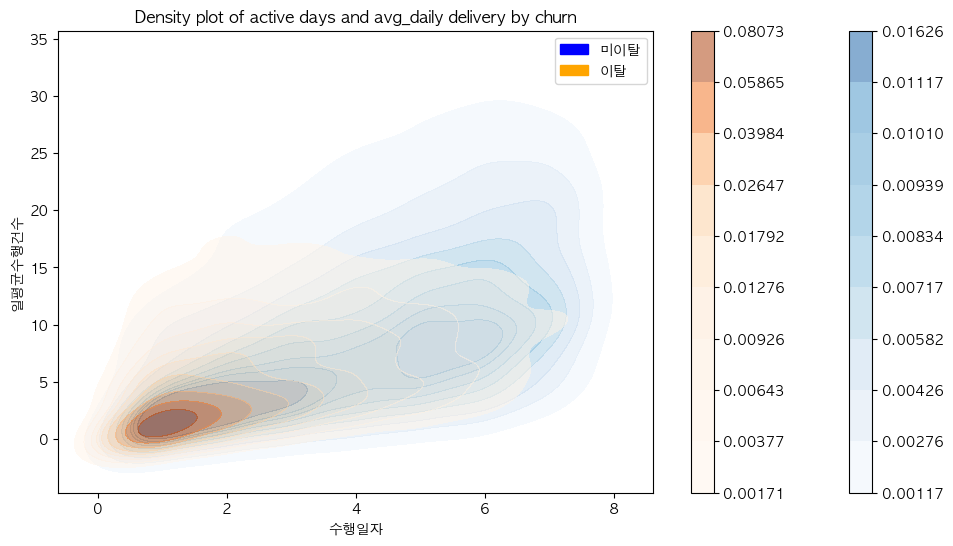

In [63]:
# 이탈 값 되돌리기
mapping  = { '미이탈' : 0 ,  '이탈' : 1}
data_filtered_both['outcome'] = data_filtered_both['outcome'].replace(mapping)

# 데이터 필터링
X_test_0 = data_filtered_both[data_filtered_both['outcome'] == 0]
X_test_1 = data_filtered_both[data_filtered_both['outcome'] == 1]

plt.figure(figsize=(12, 6))

# KDE plot
# `cbar=True`를 추가하여 컬러 바를 그래프에 추가
# `thresh`를 설정하여 밀도가 낮은 영역을 숨기기
sns.kdeplot(data=X_test_0, x='active_days', y='avg_daily_delivery', cmap='Blues', shade=True, alpha=0.5, cbar=True, thresh=0.05)
sns.kdeplot(data=X_test_1, x='active_days', y='avg_daily_delivery', cmap='Oranges', shade=True, alpha=0.5, cbar=True, thresh=0.05)

plt.xlabel('수행일자')
plt.ylabel('일평균수행건수')
plt.title('Density plot of active days and avg_daily delivery by churn')

# Manual legend
blue_patch = mpatches.Patch(color='blue', label='미이탈')
orange_patch = mpatches.Patch(color='orange', label='이탈')
plt.legend(handles=[blue_patch, orange_patch])

# 저장할 디렉토리 생성
os.makedirs('graphs', exist_ok=True)  

# 그래프를 파일로 저장
plt.savefig("graphs/bike/density_plot.png")

# 그래프 표시
plt.show()

# 4. train, test set split 

In [64]:
train_set, test_set = train_test_split(data_filtered_both, test_size = 0.25, 
                                       stratify = data_filtered_both['outcome'], random_state=1234)
X_train = train_set[['active_days', 'avg_daily_delivery']]
y_train = train_set['outcome']
X_test = test_set[['active_days', 'avg_daily_delivery']]
y_test = test_set['outcome']

print(X_train.shape, X_test.shape)  #2,468, 823
print(y_train.value_counts())
print(y_test.value_counts())

(2468, 2) (823, 2)
outcome
0    1627
1     841
Name: count, dtype: int64
outcome
0    542
1    281
Name: count, dtype: int64


# 5. Decision Tree

Training Accuracy: 0.7208
Test Accuracy: 0.7254


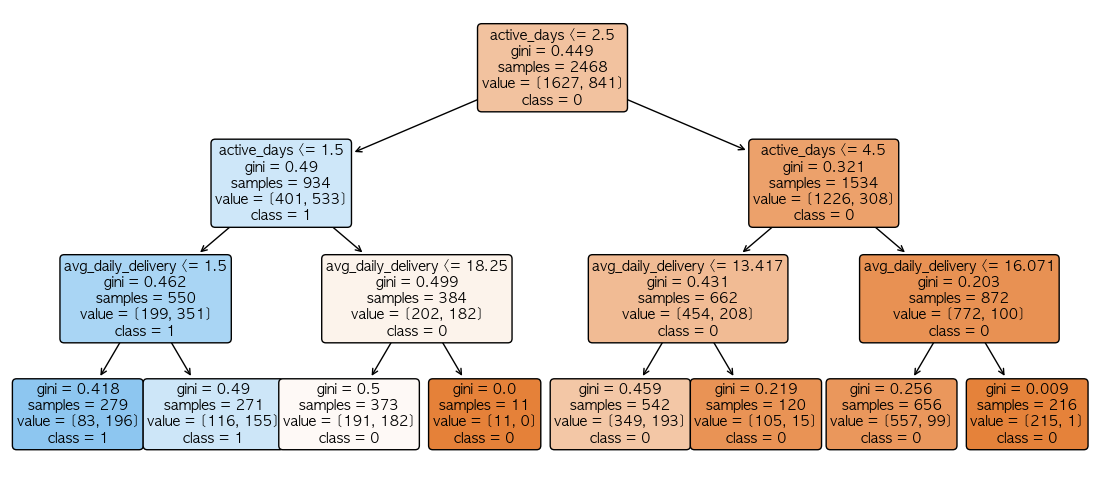

In [65]:
# model 학습 
dep_n = 3
random.seed(2234)
clf = DecisionTreeClassifier(max_depth = dep_n)  
clf = clf.fit(X_train, y_train)

# 모델의 정확도 확인
print(f"Training Accuracy: {clf.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.4f}")

# Decision Tree 시각화
fig, ax = plt.subplots(figsize=(14, 6))
tree.plot_tree(clf, filled=True, feature_names=['active_days', 'avg_daily_delivery'], class_names=['0', '1'], rounded=True, fontsize=10)
plt.savefig("graphs/DT tree.png")
plt.show()


Optimal max_depth is 3
Training Accuracy: 0.7208
Test Accuracy: 0.7254


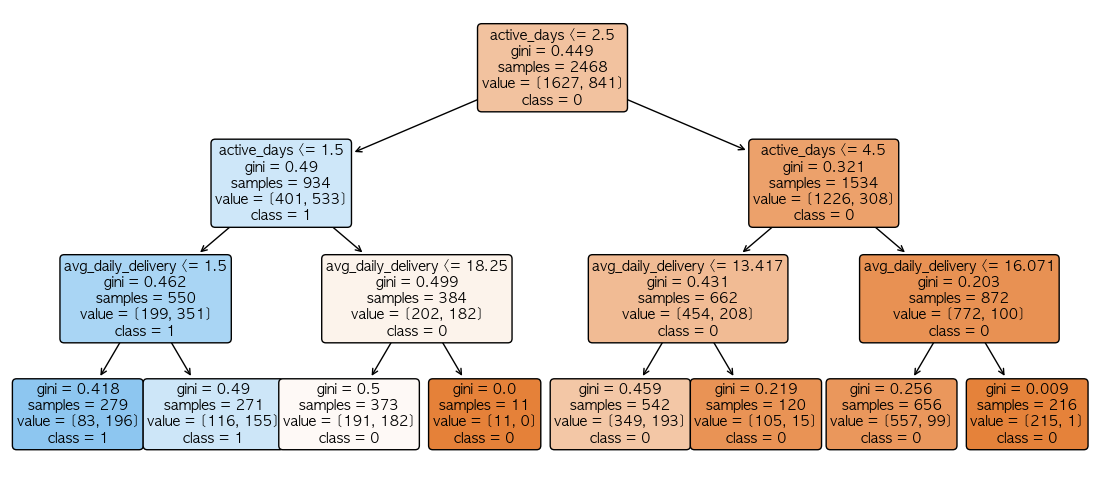

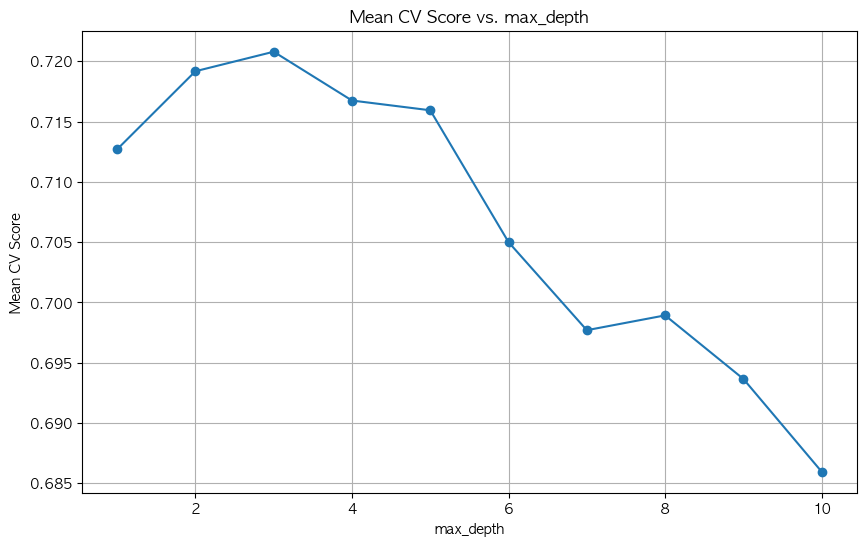

In [66]:
depth_range = list(range(1, 11))  # 1부터 10까지의 깊이를 테스트
cv_scores = []

for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(clf, X_train, y_train, cv=10)  # 5-fold 교차 검증
    cv_scores.append(scores.mean())

# 교차 검증 점수가 가장 높은 max_depth 값 찾기
optimal_depth = depth_range[cv_scores.index(max(cv_scores))]
print(f"Optimal max_depth is {optimal_depth}")

# 최적의 max_depth 값으로 모델 학습
clf = DecisionTreeClassifier(max_depth=optimal_depth)
clf = clf.fit(X_train, y_train)

# 모델의 정확도 확인
print(f"Training Accuracy: {clf.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.4f}")

# Decision Tree 시각화
fig, ax = plt.subplots(figsize=(14, 6))
tree.plot_tree(clf, filled=True, feature_names=['active_days', 'avg_daily_delivery'], class_names=['0', '1'], rounded=True, fontsize=10)
plt.savefig("graphs/dt tree 1.png")
plt.show()

# 교차 검증 점수에 따른 max_depth 값의 변화를 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.plot(depth_range, cv_scores, marker='o', linestyle='-')
plt.xlabel("max_depth")
plt.ylabel("Mean CV Score")
plt.title("Mean CV Score vs. max_depth")
plt.grid(True)
plt.savefig("graphs/cv_dt tree.png")
plt.show()

# 6. 기준에 들어오는 데이터 수 확인

In [ ]:
run = data_filtered_both[((data_filtered_both['day_cnt'] <= 2.5) & (data_filtered_both['avg_cnt'] <= 1.5))]
print(run.shape)
print(run['outcome'].value_counts())

In [ ]:
print(data_filtered_both.shape)

In [ ]:
run = train_set[((train_set['day_cnt'] <= 2.5) & (train_set['avg_cnt'] <= 1.5))]
print(run.shape)
print(run['outcome'].value_counts())